# APS360 Group Project

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import os

In [11]:
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


## Dataset Loading

In [12]:
FONT_DATASET_PATH = "./fonts_image_dataset"

def custom_collate_fn(batch):
    
    # Use the default collate function to batch the data (images)
    batch = default_collate(batch)
    images, labels = batch
    
    # Apply one-hot encoding to the labels
    labels = F.one_hot(labels)

    return images, labels

def load_dataset(dataset_path, batch_size):

    # Convert the images to tensors and normalize them
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
    gestures_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform=transform)

    # Create a list of indices for all the images in the dataset
    dataset_size = len(gestures_dataset)
    indices = list(range(dataset_size))

    np.random.seed(0)
    np.random.shuffle(indices)

    # Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
    split1 = int(0.6 * dataset_size)
    split2 = int(0.8 * dataset_size)
    train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

    # Create a sampler for the training, validation, and testing sets
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(gestures_dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, gestures_dataset.classes


## Baseline Model

In [13]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x


## Training & Output Visualization

In [14]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, criterion):
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
                
            # Forward pass
            outputs = net(inputs)
            
            # Calculate the statistics
            total_err += total_error(outputs, labels)
            total_loss += criterion(outputs, labels.float()).item()
            total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss


def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, batch_size=128, learning_rate=0.01, num_epochs=30):

    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(dataset_path, batch_size)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_error = 1
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs, training = True)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        # Store the statistics in the numpy arrays
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        
        # Print the statistics
        print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
        
        # Save the best model
        if train_err[epoch] <= min_validation_error:
            min_validation_error = train_err[epoch]
            torch.save(net.state_dict(), f"{model_name}/best_baseline_model")

    print('Finished Training')

    # Write the loss/err into CSV file for plotting later
    np.savetxt(f"{model_name}/train_err.csv", train_err)
    np.savetxt(f"{model_name}/train_loss.csv", train_loss)
    np.savetxt(f"{model_name}/val_err.csv", val_err)
    np.savetxt(f"{model_name}/val_loss.csv", val_loss)

def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Done Loading Data
Starting Training
Epoch 1: Train err: 0.915, Train loss: 3.570370626449585 | Validation err: 0.925, Validation loss: 2.30335795879364
Epoch 2: Train err: 0.87, Train loss: 2.270203447341919 | Validation err: 0.905, Validation loss: 2.1877546310424805
Epoch 3: Train err: 0.7983333333333333, Train loss: 2.0208898067474363 | Validation err: 0.87, Validation loss: 2.0982712507247925
Epoch 4: Train err: 0.7283333333333334, Train loss: 1.8957581520080566 | Validation err: 0.78, Validation loss: 2.134963274002075
Epoch 5: Train err: 0.5983333333333334, Train loss: 1.7850481033325196 | Validation err: 0.77, Validation loss: 2.1801347732543945
Epoch 6: Train err: 0.5766666666666667, Train loss: 1.6710625171661377 | Validation err: 0.745, Validation loss: 2.277278780937195
Epoch 7: Train err: 0.5566666666666666, Train loss: 1.617064070701599 | Validation err: 0.735, Validation loss: 2.2656596899032593
Epoch 8: Train err: 0.51, Train loss: 1.50061993598938 | Validation err: 0.81

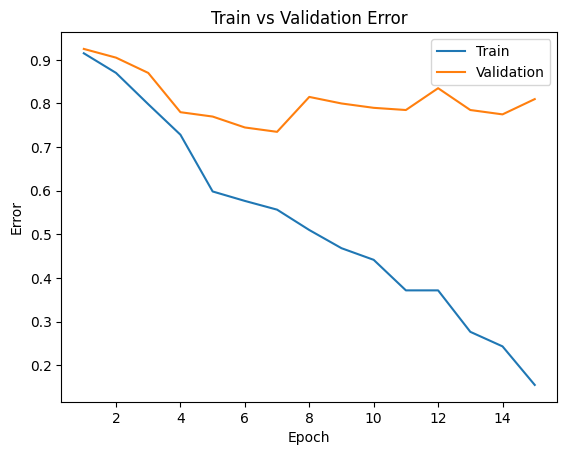

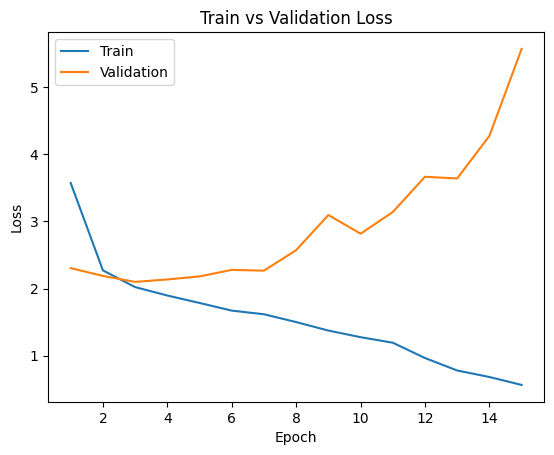

In [15]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
net = BaselineModel().to(device)
train_net(net, "baseline_model", learning_rate=0.01, num_epochs=15)
plot_training_curve("baseline_model")

In [16]:
class PrimaryModel1(nn.Module):
    def __init__(self):
        super(PrimaryModel1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

        self.conv7 = nn.Conv2d(1, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv8 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv9 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*28*28, 256)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 10)

    def forward(self, x, training=False):
        x = self.pool(F.relu(self.conv1(x))) #32x112x112
        x = self.pool(F.relu(self.conv2(x))) #64x56x56
        x = self.pool(F.relu(self.conv3(x))) #128x28x28

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x)) 
        x = F.relu(self.conv6(x))

        x = self.bn1(self.pool(F.relu(self.conv7(x))))
        x = self.bn2(self.pool(F.relu(self.conv8(x))))
        x = self.bn3(self.pool(F.relu(self.conv9(x))))
        
        x = x.view(-1, 128*28*28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.fc6(x)

        return x

Done Loading Data
Starting Training
Epoch 1: Train err: 0.9083333333333333, Train loss: 6.1705381870269775 | Validation err: 0.905, Validation loss: 2.4102628231048584
Epoch 2: Train err: 0.8733333333333333, Train loss: 2.312114953994751 | Validation err: 0.905, Validation loss: 6.145777225494385
Epoch 3: Train err: 0.855, Train loss: 2.263834095001221 | Validation err: 0.895, Validation loss: 2.93480908870697
Epoch 4: Train err: 0.8633333333333333, Train loss: 2.2518037796020507 | Validation err: 0.905, Validation loss: 5.858860731124878
Epoch 5: Train err: 0.855, Train loss: 2.201368570327759 | Validation err: 0.925, Validation loss: 2.895115613937378
Epoch 6: Train err: 0.8116666666666666, Train loss: 2.1472501277923586 | Validation err: 0.89, Validation loss: 2.8281593322753906
Epoch 7: Train err: 0.8316666666666667, Train loss: 2.12487850189209 | Validation err: 0.91, Validation loss: 5.398165702819824
Epoch 8: Train err: 0.79, Train loss: 1.998936653137207 | Validation err: 0.905

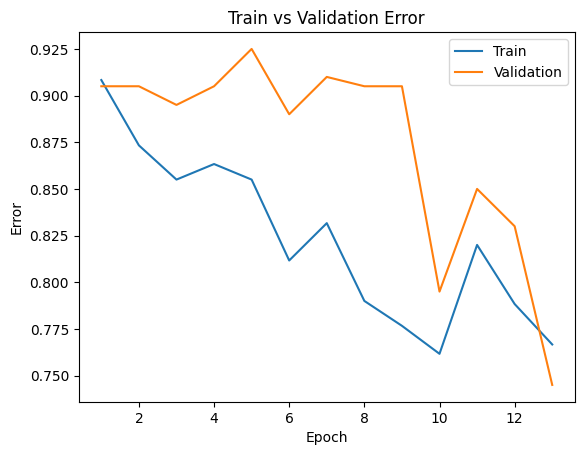

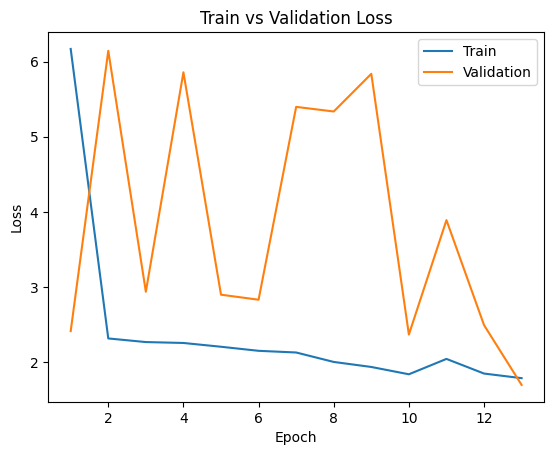

In [17]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
netPM1 = PrimaryModel1().to(device)
train_net(netPM1, "primary_model1", learning_rate=0.005, num_epochs=13)
plot_training_curve("primary_model1")